In [ ]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Reshape, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
%matplotlib inline

In [ ]:
#데이터 불러오기(경로)
train_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_x_df.csv')
train_y_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_y_df.csv')
test_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/test_x_df.csv')
sample_submission=pd.read_csv('/content/drive/MyDrive/capstone2021/sample_submission.csv')
train_x_df = train_x_df.astype('float')
train_y_df = train_y_df.astype('float')
test_x_df = test_x_df.astype('float')
sample_submission=sample_submission.astype('float')

In [ ]:
# 3차원 array로 변경
def df2d_to_array3d(df_2d):

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

def kbindiscreter(input_array):
  kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal')
  processed_data = np.zeros((input_array.shape[0], input_array.shape[1], 1))
  for i in range(input_array.shape[0]):
    # coin_index_export args : (input_array, coin_num)
    processing_array = input_array[i,:,1]
    #globals()['outliery_array{}'.format(i)] = train_y_array[outlier[i],:,1]
    kb.fit(processing_array.reshape(input_array.shape[1],1))
    processed_fit = kb.transform(processing_array.reshape(input_array.shape[1],1))
    #globals()['outliery_fit{}'.format(i)] = kb.transform(globals()['outliery_array{}'.format(i)].reshape(120,1))
    processed_data[i,:,:] = processed_fit
  return processed_data

In [ ]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [ ]:
xarray = kbindiscreter(train_x_array)
yarray = kbindiscreter(train_y_array)

In [ ]:
df2 = xarray[:100,:].reshape(100,1380,1)

In [ ]:
X_train = []
y_train = []
n_future = 1 # Number of days we want to predict into the future.
n_past = 120 # Number of past days we want to use to predict future.
for idx in range(df2.shape[0]):
    for i in range(n_past, df2.shape[1] - n_future +1):
        X_train.append(df2[idx, i - n_past:i,:])
        y_train.append(df2[idx, i:i+n_future, ])
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (126000, 120, 1).
y_train shape == (126000, 1, 1).


In [ ]:
x_traina = np.zeros((X_train.shape[0],X_train.shape[1],10))
for i in range(X_train.shape[0]):
  for j in range(X_train.shape[1]):
    for k in range(10):
      if X_train[i,j,:] ==k:
        x_traina[i,j,k] =1

In [ ]:
y_traina = np.zeros((y_train.shape[0],10))
for i in range(y_train.shape[0]):
  for j in range(10):
    if y_train[i] == j:
      y_traina[i,j] = 1

In [ ]:
model = Sequential()
model.add(Conv1D(64,10, activation='relu', input_shape=(x_traina.shape[1],x_traina.shape[2] )))
model.add(Conv1D(64,5, activation='relu'))
model.add(Conv1D(32,4, activation='relu'))
model.add(Conv1D(16,4, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_traina,y_traina,epochs=50, validation_split=0.2,shuffle=True)

Epoch 1/50
3150/3150 [==============================] - 110s 33ms/step - loss: 0.9232 - accuracy: 0.6591 - val_loss: 0.6332 - val_accuracy: 0.7836
Epoch 2/50
3150/3150 [==============================] - 105s 33ms/step - loss: 0.6223 - accuracy: 0.7775 - val_loss: 0.6156 - val_accuracy: 0.7888
Epoch 3/50
3150/3150 [==============================] - 106s 34ms/step - loss: 0.5944 - accuracy: 0.7885 - val_loss: 0.6009 - val_accuracy: 0.7935
Epoch 4/50
3150/3150 [==============================] - 106s 34ms/step - loss: 0.5718 - accuracy: 0.7947 - val_loss: 0.6135 - val_accuracy: 0.7837
Epoch 5/50
3150/3150 [==============================] - 107s 34ms/step - loss: 0.5499 - accuracy: 0.8017 - val_loss: 0.6290 - val_accuracy: 0.7867
Epoch 6/50
3150/3150 [==============================] - 106s 34ms/step - loss: 0.5210 - accuracy: 0.8093 - val_loss: 0.6491 - val_accuracy: 0.7742
Epoch 7/50
3150/3150 [==============================] - 107s 34ms/step - loss: 0.4943 - accuracy: 0.8156 - val_loss: 0

In [ ]:
# train 값 plotting

aa =x_traina[729:829,:,:] 
bb =y_traina[729:829,:]
predictions = model.predict(aa.reshape(100,120,10))

In [ ]:
# prediction 값 원 핫 인코딩 -> '정수값
fa = []
for i in range(100):
  fc = model.predict(aa[i].reshape(1,120,10))
  fa.append(np.argmax(fc))

In [ ]:
# real 값 원 핫 인코딩 -> '정수값
fb = []
for i in range(100):
  fb.append(np.argmax(bb[i]))

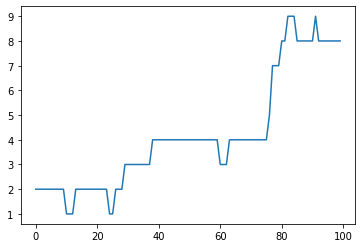

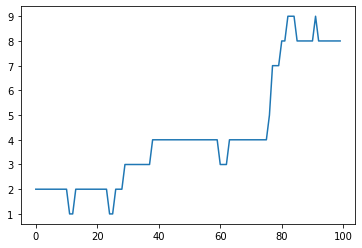

In [ ]:
#plotting
plt.plot(fa, label="predictions")
plt.show()
plt.plot(fb, label="real")

In [ ]:
#train set auto regression

aa =x_traina[800,:,:]
yhat=[]
x= aa.reshape(1,120,10)

In [ ]:
for i in range(100):
  x=x.reshape(1,120,10)
  fc = model.predict(x)
  yhat.append(np.argmax(fc))
  fd = np.zeros((1,10))
  for j in range(10):
    if j==np.argmax(fc):
      fd[0,j] = 1
  
  x=x.reshape(120,10)
  x=np.vstack([x,fd])
  x=x[1:,:]

In [ ]:
bb = []
for x in range(100):
  bb.append(np.argmax(y_traina[800+x]))

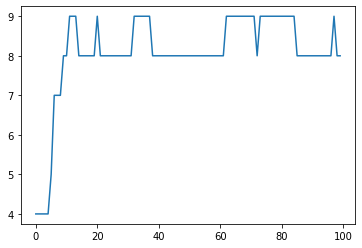

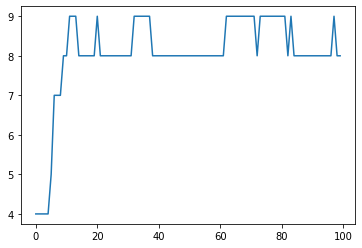

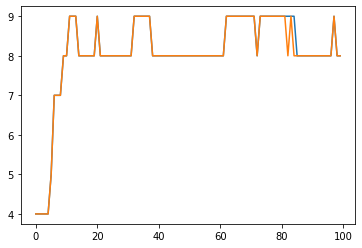

In [ ]:
# train set auto regression plotting
plt.plot(yhat,label="prediction")
plt.show()
plt.plot(bb, label="real")
plt.show()
plt.plot(yhat,label="prediction")
plt.plot(bb, label="real")

In [ ]:
#val set auto regression
num= 100000
aa =x_traina[100000,:,:]
yhat=[]
x= aa.reshape(1,120,10)

In [ ]:
for i in range(100):
  x=x.reshape(1,120,10)
  fc = model.predict(x)
  yhat.append(np.argmax(fc))
  fd = np.zeros((1,10))
  for j in range(10):
    if j==np.argmax(fc):
      fd[0,j] = 1
  
  x=x.reshape(120,10)
  x=np.vstack([x,fd])
  x=x[1:,:]

In [ ]:
bb = []
for x in range(100):
  bb.append(np.argmax(y_traina[num+x]))

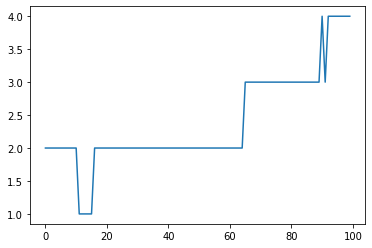

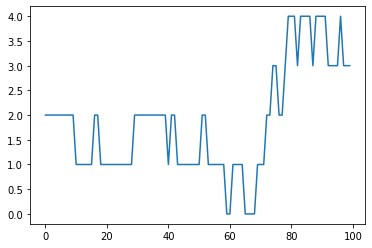

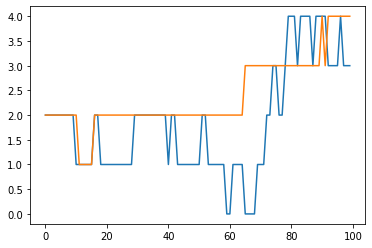

In [ ]:
plt.plot(yhat,label="prediction")
plt.show()
plt.plot(bb, label="real")
plt.show()
plt.plot(bb, label="real")
plt.plot(yhat,label="prediction")